# Set up the working directory and enviroment

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/")

## Assign folders for storing input data, object, and output
1. 'data' folder: storing .mtx or h5 from 10xGenomic sequencing 
2. 'interim' folder: storing h5ad object after processing and its output files, e.g., top_markers.csv
3. 'figures' folder: automatically generated

In [4]:
%ls -lth

total 136M
-rw------- 1 root root 3.8M May 18 13:45 Trouble_shooting_scanpy_pool_iPSC.ipynb
-rw------- 1 root root 1.9M May 14 23:51 demultiplexing_pool_iPSC_21April.ipynb
-rw------- 1 root root 3.6M May 14 23:35 scanpy_pool_iPSC.ipynb
-rw------- 1 root root 3.0K May 13 16:18 demultiplexing_wholeset_4May2020.py
drwx------ 2 root root 4.0K Apr 21 13:34 figures/
drwx------ 2 root root 4.0K Apr 21 13:03 vireo_out/
drwx------ 2 root root 4.0K Apr 17 16:32 vireo/
drwx------ 2 root root 4.0K Apr 17 16:32 cellSNP/
-rw------- 1 root root 112M Apr 16 22:46 pool_iPSC_before_neighbors.h5ad
-rw------- 1 root root  16M Apr 16 22:30 filtered_feature_bc_matrix.h5
drwx------ 2 root root 4.0K Apr 16 22:29 filtered_feature_bc_matrix/
drwx------ 2 root root 4.0K Apr 16 22:24 scanpy_out/


In [0]:
#! mkdir scanpy_out
results_file = 'scanpy_out/pool_iPSC_normalized_wholeset_test.h5ad'

## Installed the required packages

In [0]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc

## Set up the displaying and print parameters

In [3]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.2


# Data preprocessing
1. Use gene symbols for the variable names (variables-axis index)
3. Write a cache file for faster subsequent reading
4. De-duplicates

In [13]:
%ls -lth forebrain/combined1_forebrain/scanpy_out/

total 705M
-rw------- 1 root root 398M May 13 22:01 combined1_forebrain_wholeset.h5ad
-rw------- 1 root root 307M May 13 21:52 combined1_forebrain.h5ad


Using the example of forebrain

find that wholeset.h5ad hasn't been normalized at all.so the data is stored as compressed matrix

In [0]:
adata_forebrain = sc.read_h5ad("forebrain/combined1_forebrain/scanpy_out/combined1_forebrain.h5ad")
adata_forebrain_whole = sc.read_h5ad("forebrain/combined1_forebrain/scanpy_out/combined1_forebrain_wholeset.h5ad")

In [15]:
adata_forebrain

AnnData object with n_obs × n_vars = 9020 × 2758 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [16]:
adata_forebrain_whole

AnnData object with n_obs × n_vars = 9039 × 20863 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [27]:
%cd forebrain/

/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/forebrain


In [0]:
def generate_wholeset_from_beginning(folder_name, n1=6500, n2=0.15):
  os.chdir(folder_name)
  file_dir = folder_name
  results_file = 'scanpy_out/'+file_dir+'_wholeset_test.h5ad'
  figure_file = '_'+file_dir+'.jpg'

  adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")
  adata.var_names_make_unique()

  sc.pp.filter_cells(adata, min_genes=200)
  sc.pp.filter_genes(adata, min_cells=3)

  mito_genes = adata.var_names.str.startswith('MT-')
  
  adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
  adata.obs['n_counts'] = adata.X.sum(axis=1).A1

  #sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save=figure_file)
  
  adata = adata[adata.obs.n_genes < n1, :]
  adata = adata[adata.obs.percent_mito < n2, :]

  #sc.pl.highest_expr_genes(adata, n_top=20, save=figure_file)
  sc.pp.normalize_total(adata, target_sum=1e4)

  sc.pp.log1p(adata)
  
  adata.raw=adata

  sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
  #sc.pl.highly_variable_genes(adata, save=figure_file)
  #adata = adata[:, adata.var.highly_variable]
  #sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
  #sc.pp.scale(adata, max_value=10)
  
  #adata.write(results_file)
  os.chdir("../")
  return adata

In [33]:
%cd ../

/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong


In [34]:
%ls

3sets_15May2020.h5ad  integrated_data/  pool_iPSC/            temp.h5ad
Excel_NGN2_vs_NIL/    NGN2/             proteomics_DIA/       test_vireo/
Florian_data/         NIL/              results_for_meeting/
forebrain/            pbmc3k/           temp2.h5ad


In [28]:
adata = generate_wholeset_from_beginning('combined1_forebrain', n1=6500, n2=0.2)

reading filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 22 cells that have less than 200 genes expressed
filtered out 12675 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:18)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [0]:
adata_temp = sc.read_h5ad("3sets_15May2020.h5ad")

In [20]:
adata_temp

AnnData object with n_obs × n_vars = 18780 × 3107 
    obs: 'batch', 'donor_id', 'donor_label', 'n_counts', 'n_genes', 'percent_mito', 'leiden', 'leiden_0.6', 'leiden_0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-iPSC', 'n_cells-combined2_hNGN2', 'highly_variable-combined2_hNGN2', 'means-combined2_hNGN2', 'dispersions-combined2_hNGN2', 'dispersions_norm-combined2_hNGN2', 'n_cells-combined2_hNIL', 'highly_variable-combined2_hNIL', 'means-combined2_hNIL', 'dispersions-combined2_hNIL', 'dispersions_norm-combined2_hNIL', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'leiden', 'leiden_0.6_colors', 'leiden_0.8_colors', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [26]:
adata_temp.X.toarray()[4000:6000,]

array([[ 2.0537198e+00, -5.6757432e-01, -3.0739734e-02, ...,
        -6.0224491e-01, -1.8089593e-03, -2.8347898e-01],
       [-1.1009636e+00, -5.3999144e-01, -3.7850674e-02, ...,
        -5.6011045e-01, -9.4439863e-04, -2.7335209e-01],
       [ 5.8611798e-01,  5.7988930e-01,  2.2520494e-02, ...,
        -2.8679246e-01, -3.8777675e-02, -4.4374698e-01],
       ...,
       [ 1.4696501e+00, -5.9783578e-01, -2.4581045e-02, ...,
        -7.2482777e-01, -7.6137092e-03, -3.0624685e-01],
       [-8.9426166e-01, -5.3213114e-01, -4.6356987e-02, ...,
         1.3493090e+00, -1.9853441e-02, -3.1644949e-01],
       [-9.3543559e-01, -5.6176937e-01, -3.6941536e-02, ...,
        -8.1208092e-01, -1.5536366e-02, -3.1473765e-01]], dtype=float32)

In [1]:
adata_temp.raw.X.toarray()[4000:6000,]

NameError: ignored

In [12]:
adata_temp

AnnData object with n_obs × n_vars = 18780 × 17238 
    obs: 'batch', 'donor_id', 'donor_label', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-iPSC', 'n_cells-combined2_hNGN2', 'highly_variable-combined2_hNGN2', 'means-combined2_hNGN2', 'dispersions-combined2_hNGN2', 'dispersions_norm-combined2_hNGN2', 'n_cells-combined2_hNIL', 'highly_variable-combined2_hNIL', 'means-combined2_hNIL', 'dispersions-combined2_hNIL', 'dispersions_norm-combined2_hNIL'

In [14]:
adata_temp.obs.donor_label.value_counts()

NCRM1-C6                        5119
nan                             2648
KUCG3-C1                        2217
PGP1-C2                         2197
KOLF2-ARID2-A02                 1886
NN0003932-C3 or NN0004297-C1    1690
LNGPI1-C1                       1657
NCRM5-C5                        1366
Name: donor_label, dtype: int64

In [18]:
adata_temp.X.toarray()[0:3000,]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.79388547,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.8678515 ,
        0.        ]], dtype=float32)

In [16]:
adata_temp.raw.X.toarray()[0:3000,]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.79388547,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.8678515 ,
        0.        ]], dtype=float32)

In [31]:
adata.X.toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.1222247],
       [0.       , 0.       , 0.       , ..., 0.       , 0.6051148,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.7123345]], dtype=float32)

In [0]:
adata.X.toarray().argmin(axis=0)

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
%ls -lth pool_iPSC/scanpy_out/

total 1.1G
-rw------- 1 root root 165M May 18 03:47 pool_iPSC_wholeset.h5ad
-rw------- 1 root root 214K May 14 23:51 pool_iPSC_adata_wholeset_with_donors2.csv
-rw------- 1 root root 165M May 14 23:51 pool_iPSC_wholeset_with_donors2.h5ad
-rw------- 1 root root 339M May 14 23:32 pool_iPSC_wholeset_with_donors.h5ad
-rw------- 1 root root 233K May 14 23:32 pool_iPSC_wholeset_with_donors.csv
-rw------- 1 root root 165M May 14 23:22 pool_iPSC_wholeset2.h5ad
-rw------- 1 root root 113M May  4 03:49 pool_iPSC_with_donors.h5ad
-rw------- 1 root root  890 Apr 21 13:32 pool_iPSC_leiden_by_donor.csv
-rw------- 1 root root 233K Apr 21 13:29 pool_iPSC_adata_with_donors.csv
-rw------- 1 root root 113M Apr 16 22:52 pool_iPSC.h5ad
-rw------- 1 root root  13K Apr 16 22:52 top_markers_pool1_neurons_hNGN2_HVG.csv


In [0]:
adata2 = sc.read_h5ad("combined1_hNGN2/scanpy_out/combined1_hNGN2_wholeset_test.h5ad")

In [0]:
adata2.raw.X.toarray().argmax(axis=0)

array([5355, 2818, 5438, ..., 1599, 5978, 4782])

In [0]:
adata2.raw.X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.79388547,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [0]:
adata = sc.read_h5ad("pool_iPSC/scanpy_out/pool_iPSC.h5ad")

In [0]:
adata.X

array([[-0.8659105 , -0.13201246, -0.10380338, ...,  0.4835015 ,
        -0.31961304, -0.11462401],
       [-0.87741   , -0.14061318, -0.09544732, ..., -0.8826276 ,
        -0.27801853, -0.16515562],
       [ 0.38261116, -0.06718602, -0.06197959, ...,  0.22123522,
        -0.25785196, -0.07450875],
       ...,
       [ 0.5236284 , -0.12750797, -0.09040586, ..., -0.86000675,
        -0.27775577, -0.14594735],
       [ 0.5097463 , -0.12577522, -0.0915628 , ...,  1.3095908 ,
        -0.28425038, -0.13747883],
       [ 0.21527064, -0.10640712, -0.08288623, ...,  0.34325606,
        -0.27947277, -0.11307669]], dtype=float32)

In [0]:
adata.raw.X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.79388547,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

## Read 10xGenomics sc-RNA sequencing data

In [0]:
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")                               

reading filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [0]:
adata.var_names_make_unique()

In [0]:
adata

AnnData object with n_obs × n_vars = 3458 × 33538 
    var: 'gene_ids', 'feature_types', 'genome'

## Basic filtering
1. cell based filtering: remove cells with less than 200 genes
2. gene based filtering: remove genes expressing in less than 3 cells

In [0]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 2 cells that have less than 200 genes expressed
filtered out 14542 genes that are detected in less than 3 cells


## Calculate the percentage of mitochondrial genes

In [0]:
mito_genes = adata.var_names.str.startswith('MT-')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

## Check sequencing quality
1. choose the threthold of gene numbers to remove, e.g., n_genes = 6500
2. choose the threthold of mitochondial genes to remove, e.g., percent_mito = 0.2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
... storing 'feature_types' as categorical
... storing 'genome' as categorical


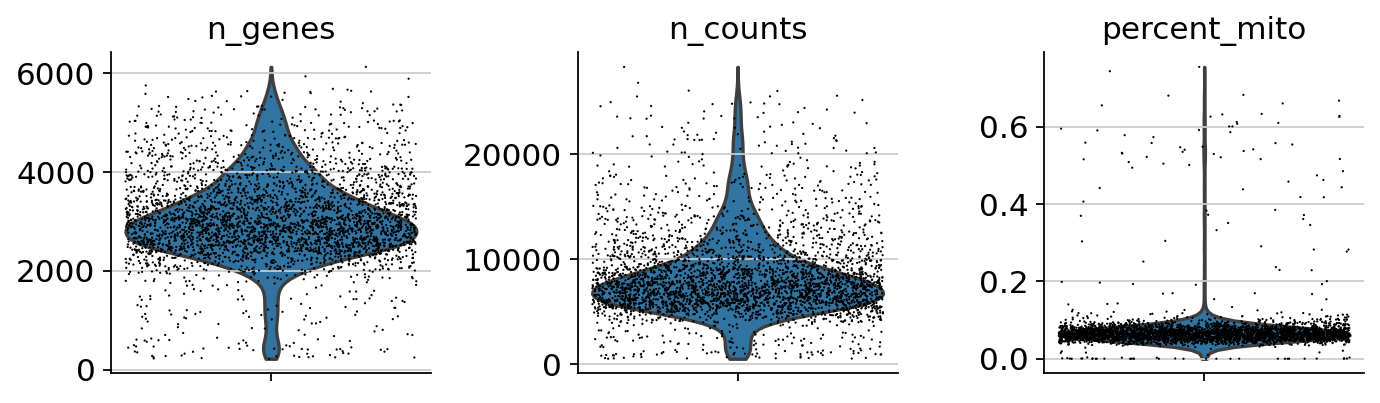

In [0]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

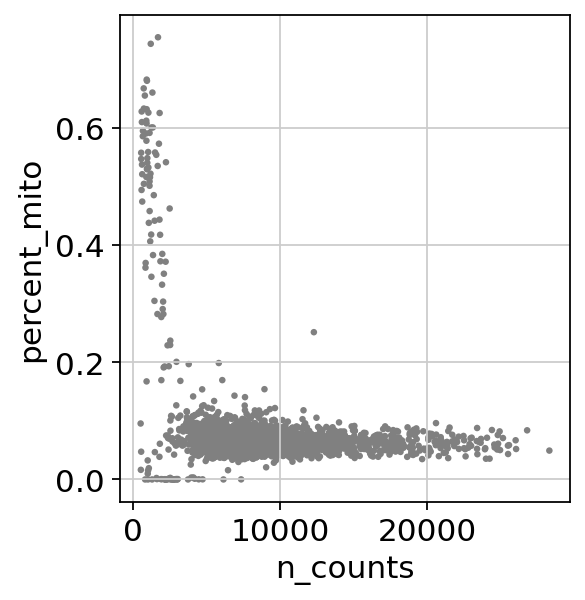

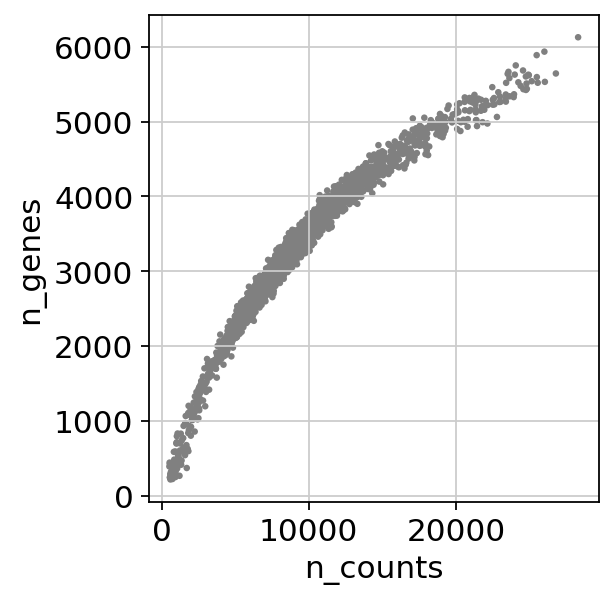

In [0]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [0]:
adata = adata[adata.obs.n_genes < 6500, :]
adata = adata[adata.obs.percent_mito < 0.2, :]
adata

View of AnnData object with n_obs × n_vars = 3381 × 18996 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [0]:
adata.X.argmax(axis=0)

matrix([[2268, 2927, 1824, ..., 1270, 3233,  471]])

## Scale and logarithmize the data
option: store the unnormalized data in .raw

In [0]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata

normalizing counts per cell
    finished (0:00:06)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [0]:
adata.write_h5ad("pool_iPSC_wholeset2.h5ad")

## Choosing highly-variable genes for further analysis
Subset is optional. If subset using adata.var.highly_variable, the adata will only contain these genes.

This time, let's try do not subset

In [0]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


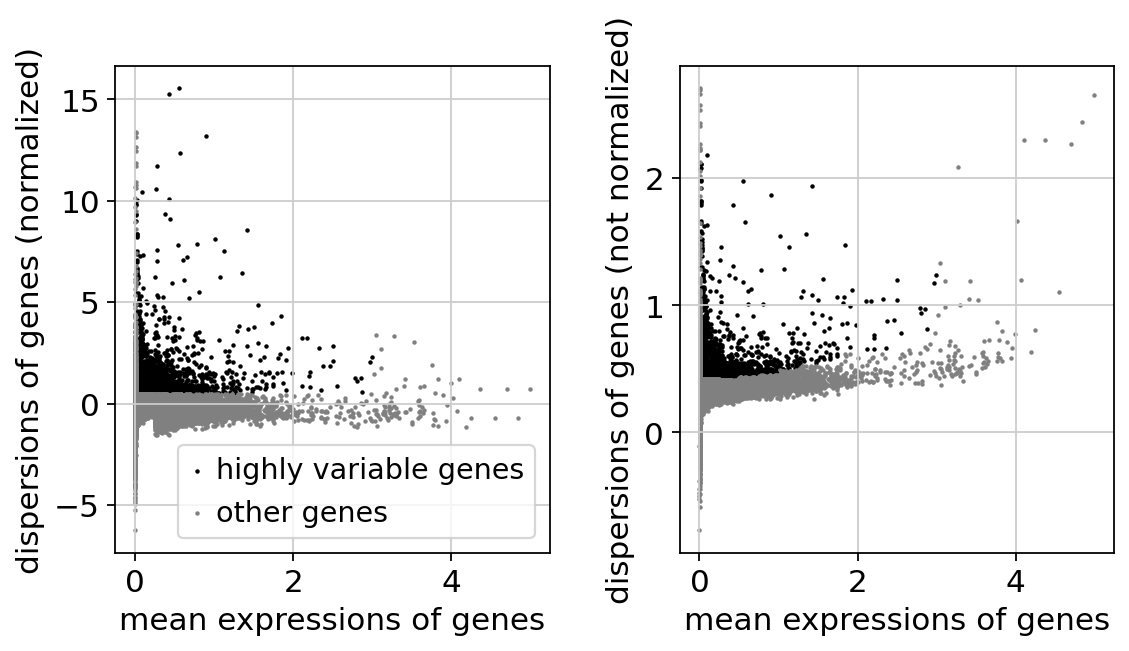

In [0]:
sc.pl.highly_variable_genes(adata)

In [0]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 3381 × 2095 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Further scale on cofounder "n_counts" and "percent_mito"
1. Regression out n_counts and percent_mito effect and scale again on adata which only contains highly-variable genes now.
2. Clip values exceeding standard deviation 10 (max_value=10)

In [0]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


    finished (0:00:12)


# Principal component analysis

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


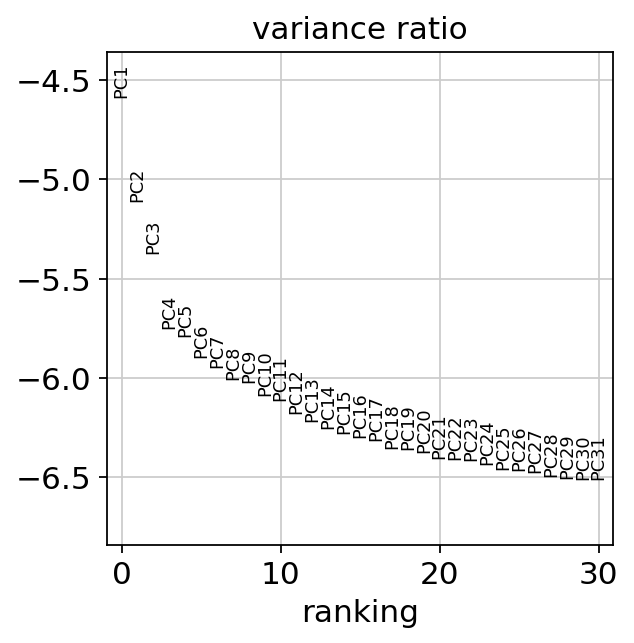

In [0]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [0]:
adata.write_h5ad("pool_iPSC_before_neighbors.h5ad")


### Computing, embedding, and clustering the neighborhood graph

1. Computing the neighborhood graph of cells using the PCA representation of the data matrix.
2. Embedding the graph in 2 dimensions using UMAP.
3. Clustering the neighborhood graph using Leiden graph-clustering method 

In [0]:
 # defaults are: n_neighbors= 20, n_pcs=50
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [0]:
# default resolution=1.0
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [0]:
adata

AnnData object with n_obs × n_vars = 3381 × 2095 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [0]:
sc.tl.leiden(adata, resolution=0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution=0.6, key_added = "leiden_0.6")

running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:01)


## Visualize the clusters

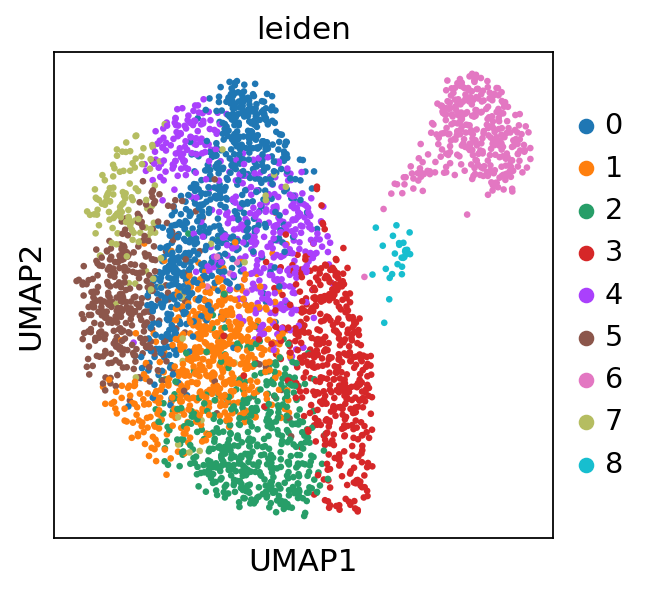

In [0]:
sc.pl.umap(adata, color=['leiden'])

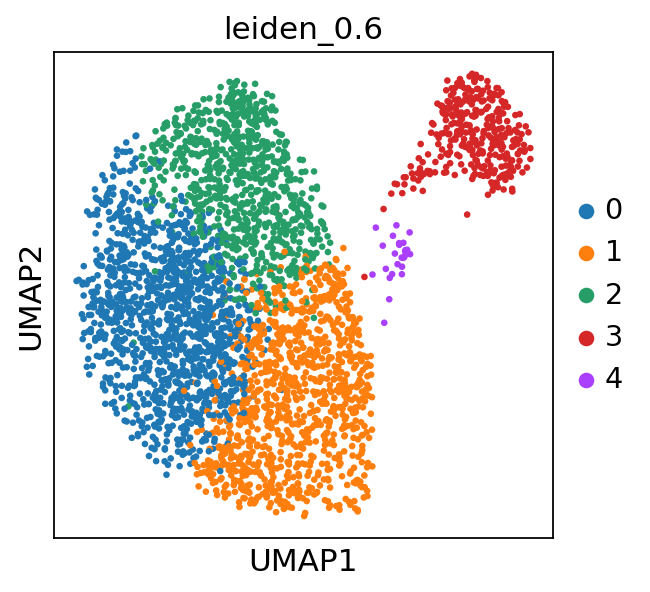

In [0]:
sc.pl.umap(adata, color=['leiden_0.6'])

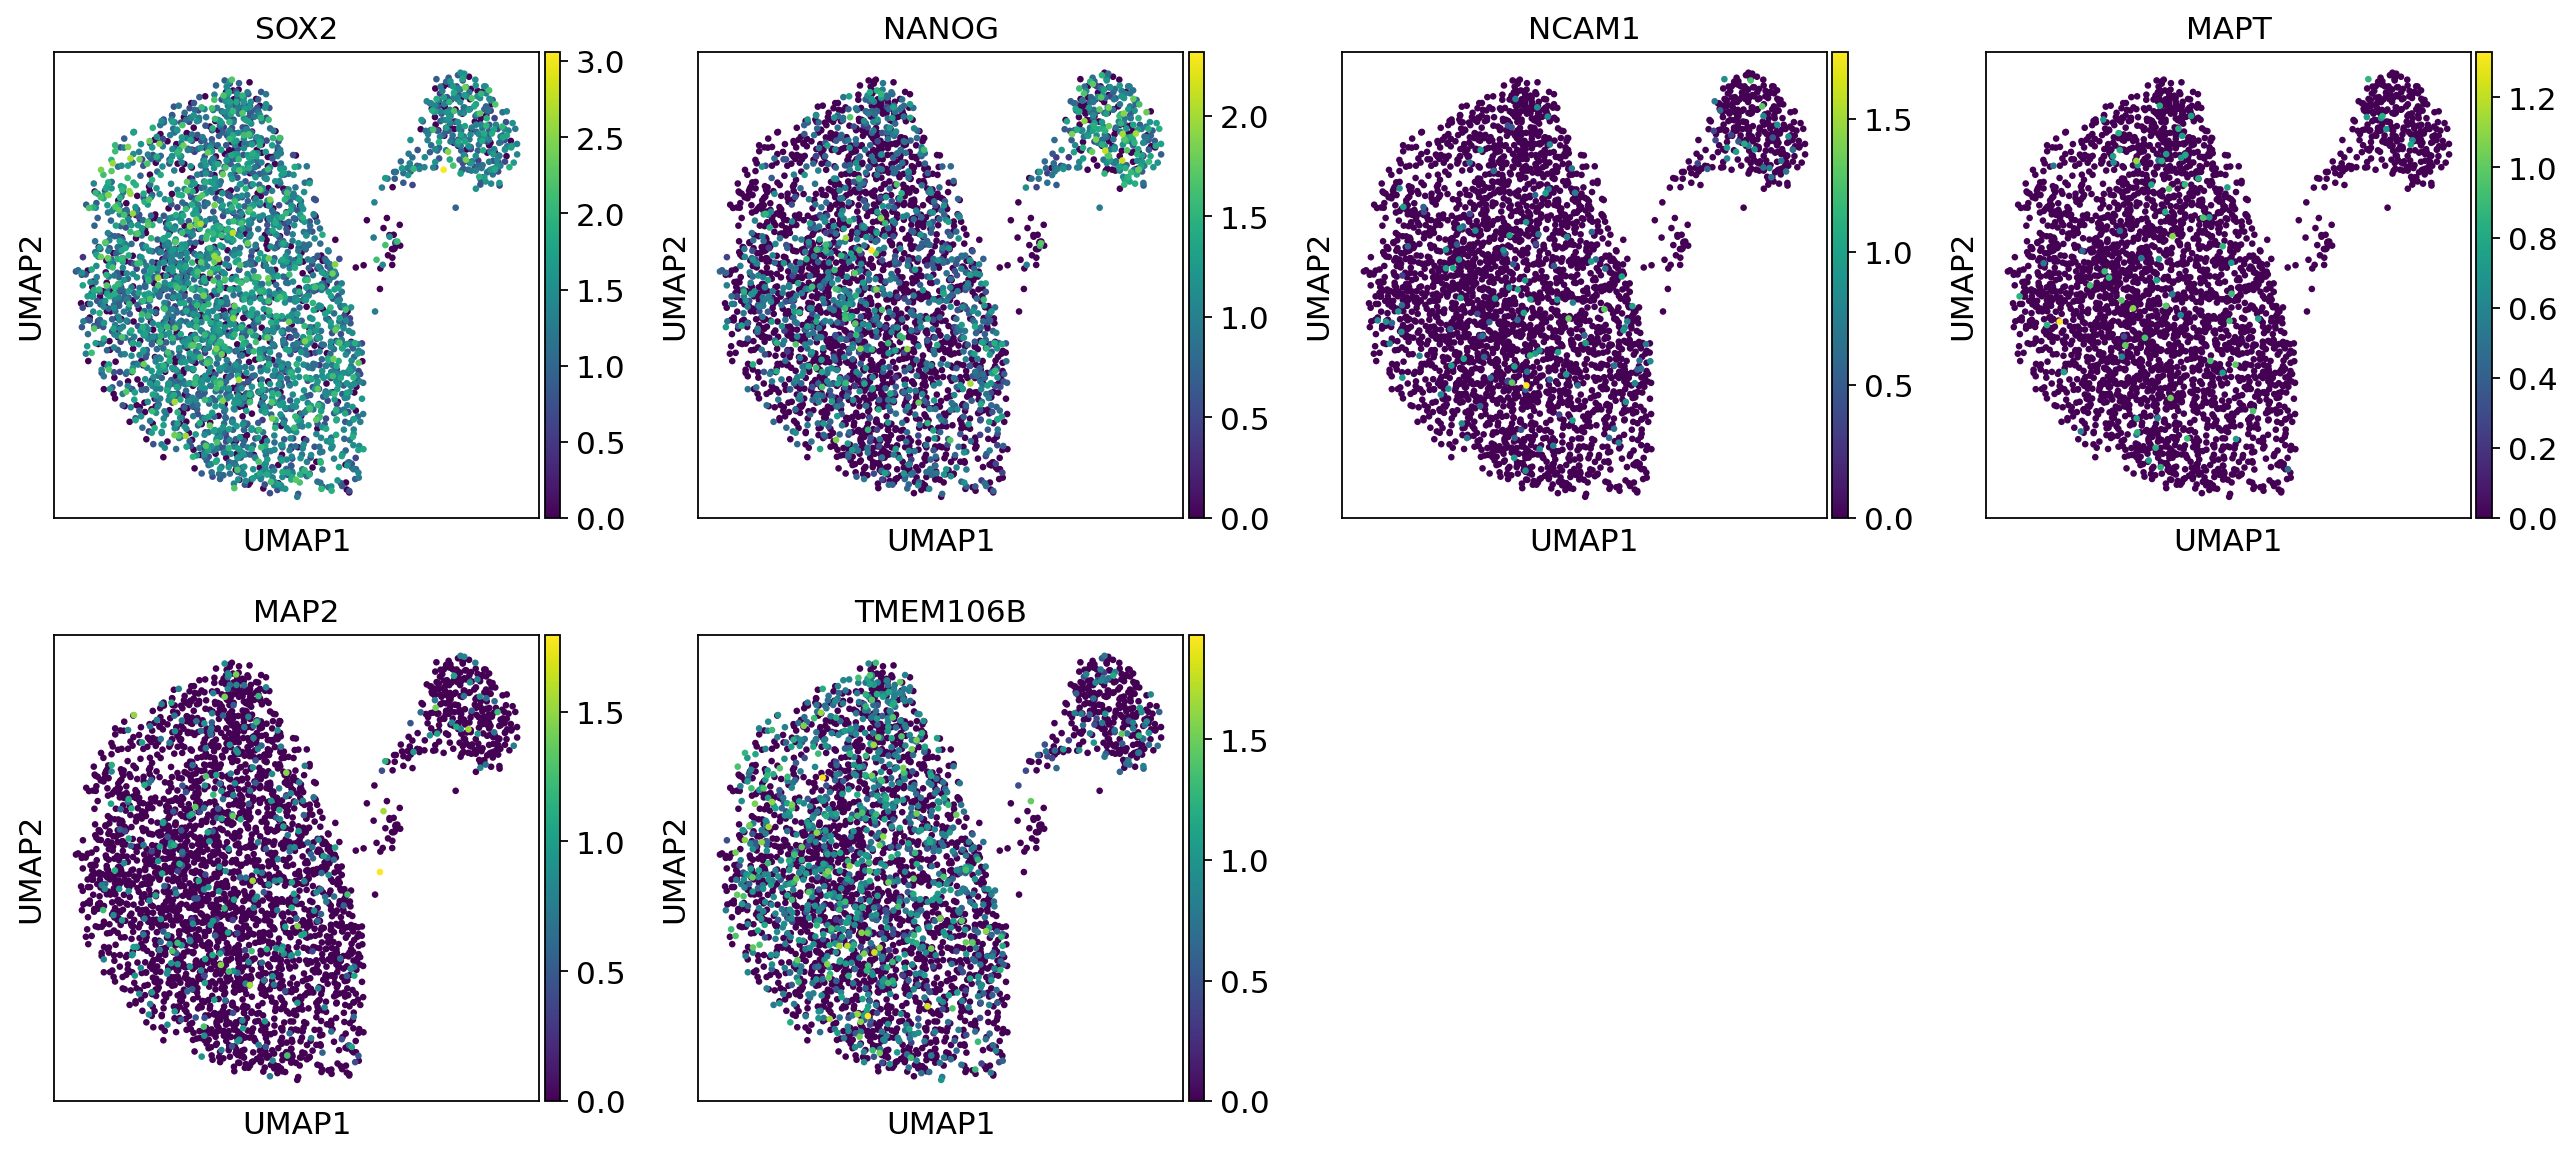

In [0]:
sc.pl.umap(adata, color=['SOX2', 'NANOG', 'NCAM1','MAPT','MAP2', 'TMEM106B'])

# Finding marker genes
one vs rest comparison using Mann-Whitney-U-test (recommend)

In [0]:
# reduce the verbosity from 3 to 2 in the setting of logging output
sc.settings.verbosity = 2 

ranking genes
    finished (0:00:04)


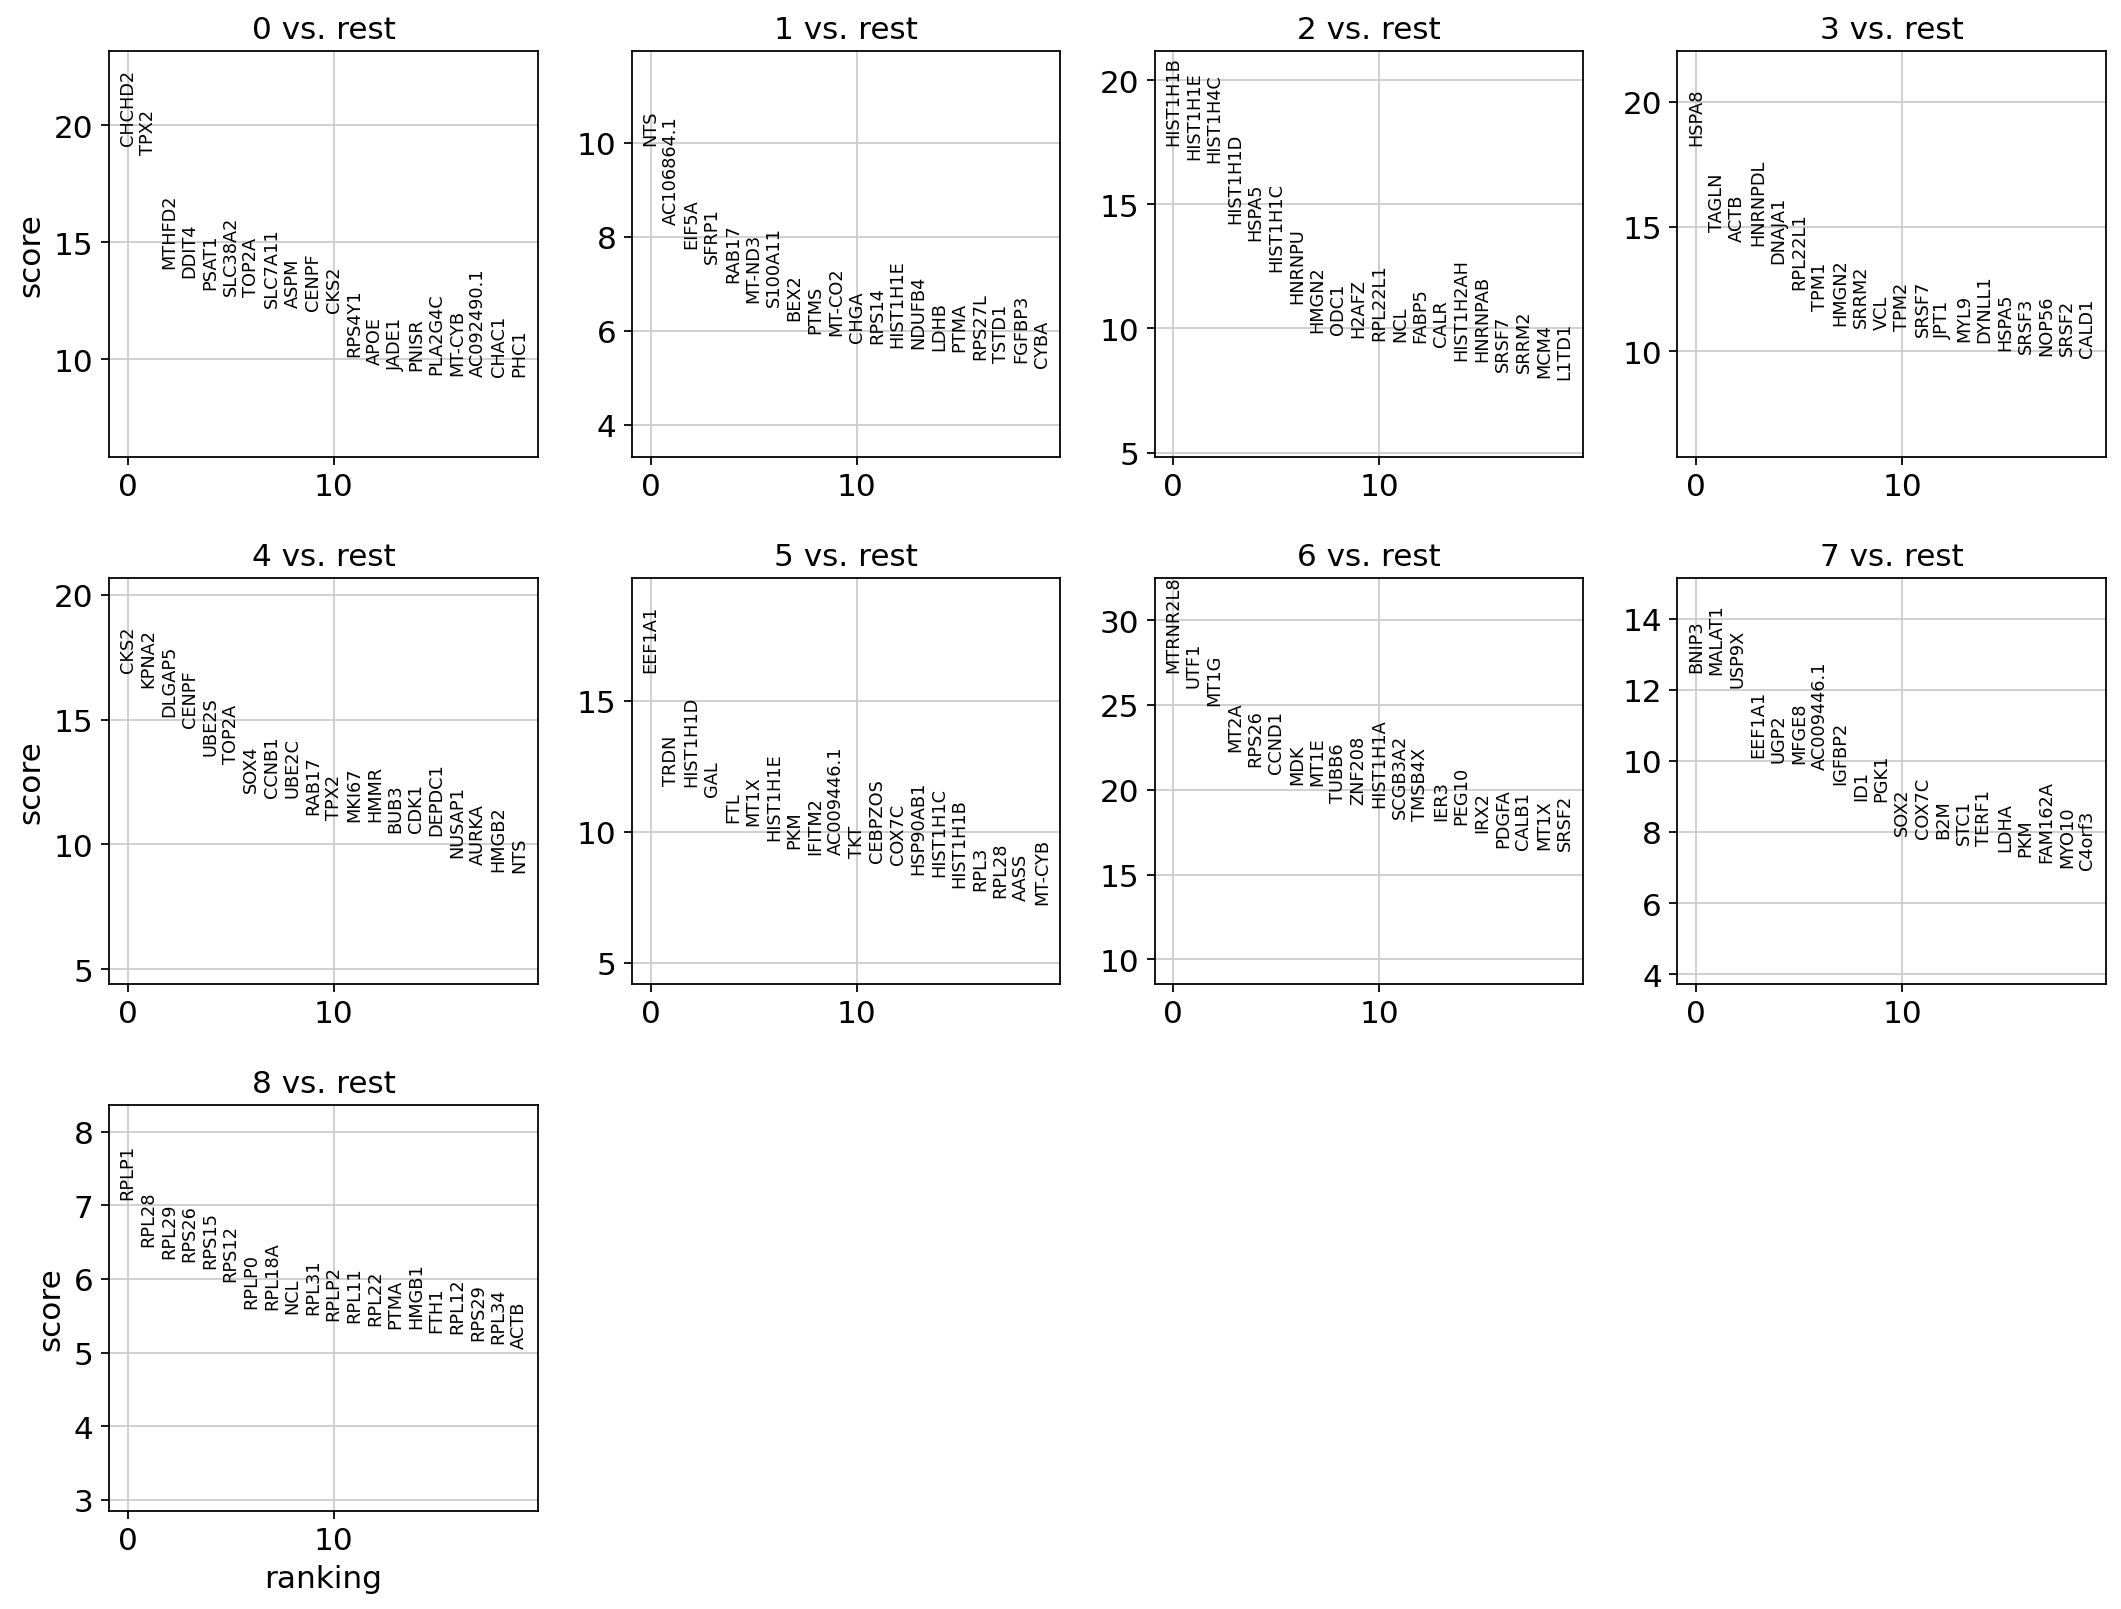

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Visualize the differential expression of marker genes across clusters
1. Differential expression a set of marker genes of a specific cluster vs the rest.
2. Differential expression of a single gene across all clusters

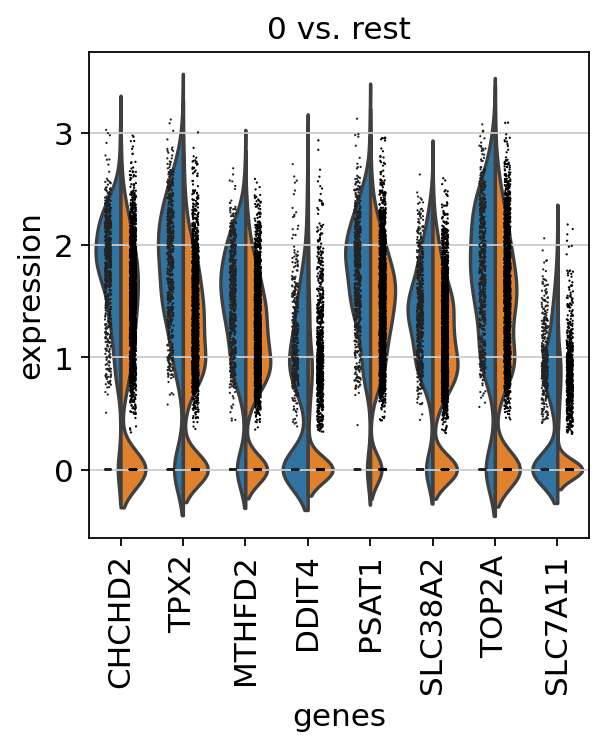

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

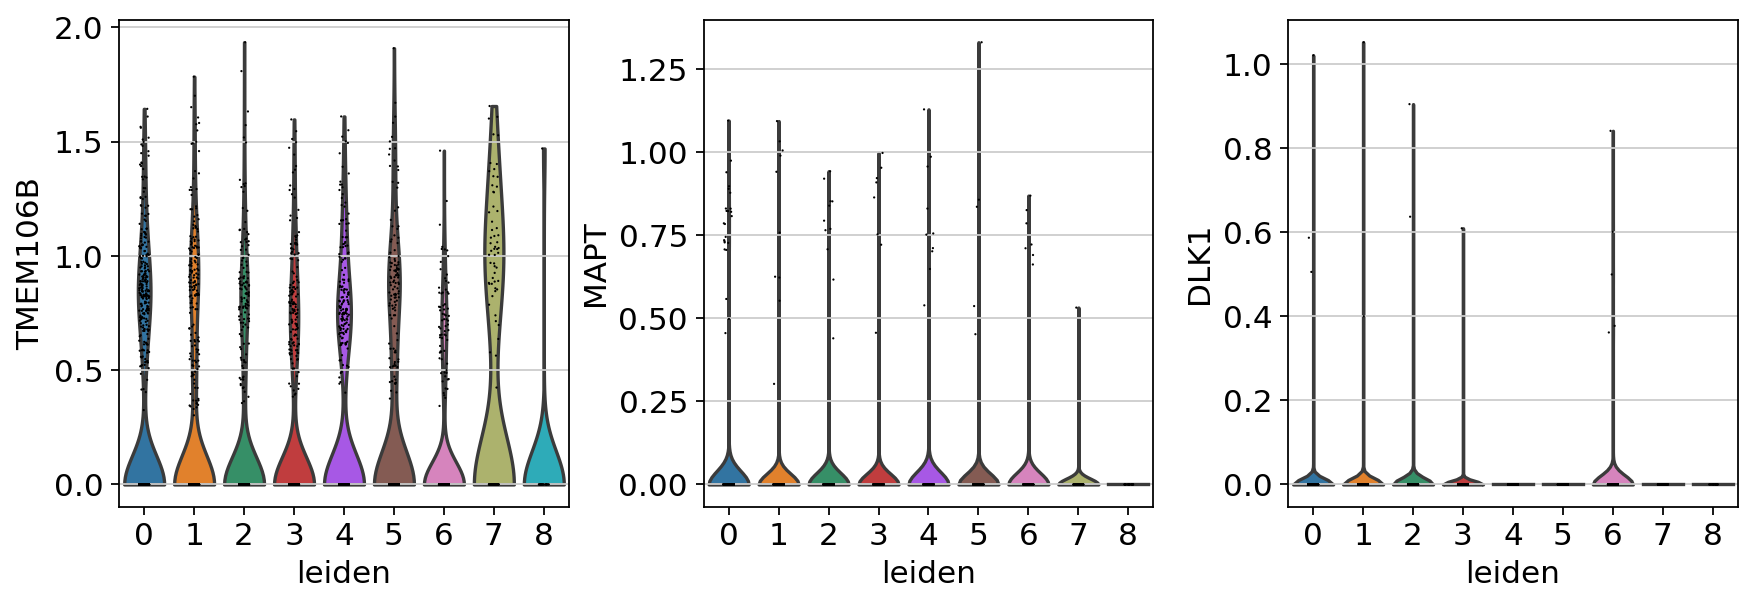

In [0]:
sc.pl.violin(adata, ['TMEM106B', 'MAPT', "DLK1"], groupby='leiden')

## Annotate cell types for all the clusters 
Based on domain knowledge and information of marker genes

Wait for disscussion for this case


In [0]:
# assign cell type names to the clusters
# new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']

# adata.rename_categories('leiden', new_cluster_names)

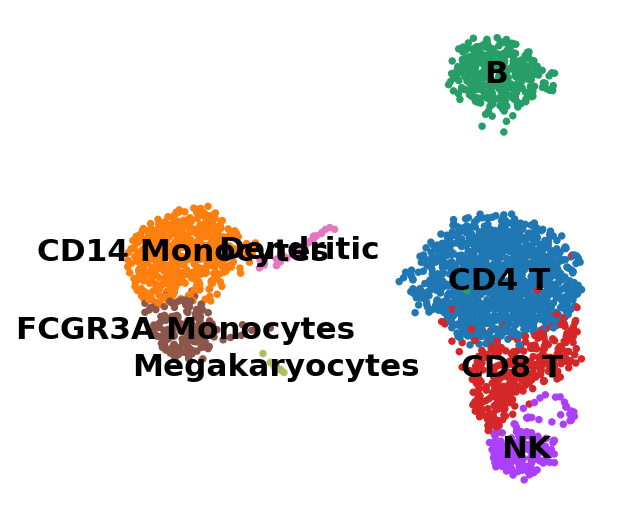

In [0]:
# it automatically generates a folder of 'figures' and save the figure inside 
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

# Export a list of marker genes

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

top_marker_genes.to_csv('scanpy_out/top_markers_pool1_neurons_hNGN2_HVG.csv')

In [0]:
top_marker_genes.head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,CHCHD2,7.316438e-82,NTS,2.321124e-23,HIST1H1B,9.563317e-68,HSPA8,1.198125e-74,CKS2,3.539287e-64,EEF1A1,2.477310e-58,MTRNR2L8,4.728347e-160,BNIP3,6.580782e-36,RPLP1,1.341831e-12
1,TPX2,1.250236e-78,AC106864.1,1.240264e-16,HIST1H1E,1.203997e-63,TAGLN,7.814502e-50,KPNA2,9.457772e-60,TRDN,5.202056e-32,UTF1,1.298089e-149,MALAT1,1.227483e-35,RPL28,1.167159e-10
2,MTHFD2,8.032417e-44,EIF5A,8.031376e-15,HIST1H4C,1.058881e-62,ACTB,4.081070e-47,DLGAP5,6.914635e-52,HIST1H1D,8.127034e-32,MT1G,6.293306e-138,USP9X,1.337591e-33,RPL29,3.179949e-10
3,DDIT4,9.673804e-42,SFRP1,1.048745e-13,HIST1H1D,4.859987e-46,HNRNPDL,2.696174e-46,CENPF,6.404495e-49,GAL,7.132507e-30,MT2A,3.700749e-110,EEF1A1,4.750817e-24,RPS26,4.338256e-10
4,PSAT1,1.136822e-38,RAB17,1.914166e-12,HSPA5,8.251040e-42,DNAJA1,7.205004e-42,UBE2S,4.782810e-42,FTL,3.756833e-25,RPS26,9.757551e-102,UGP2,2.256739e-23,RPS15,7.487067e-10


In [0]:
# get a list of top20 marker genes of cluster 1
marker_genes_cluster1 = top_marker_genes["1_n"][:20].values

# Visulize gene differential expression 
maker genes or other gene of interest


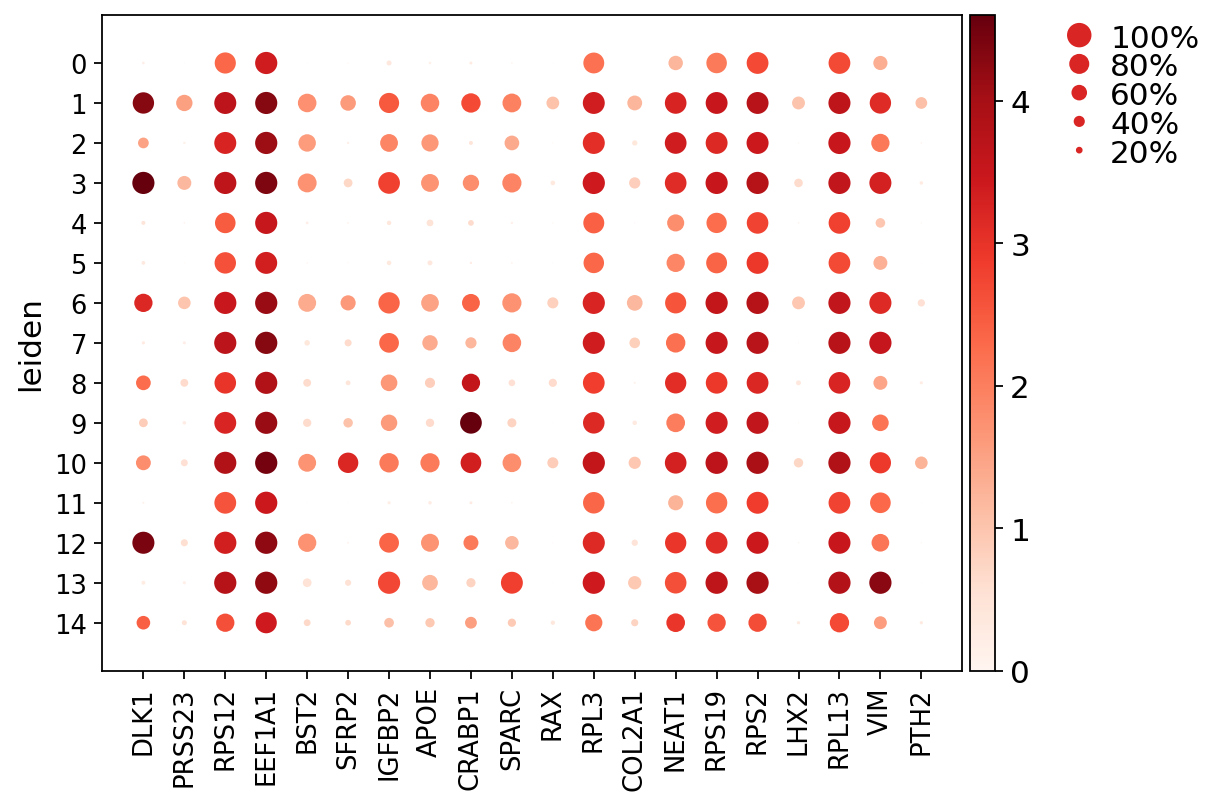

In [0]:
ax = sc.pl.dotplot(adata, marker_genes_cluster1, groupby='leiden')

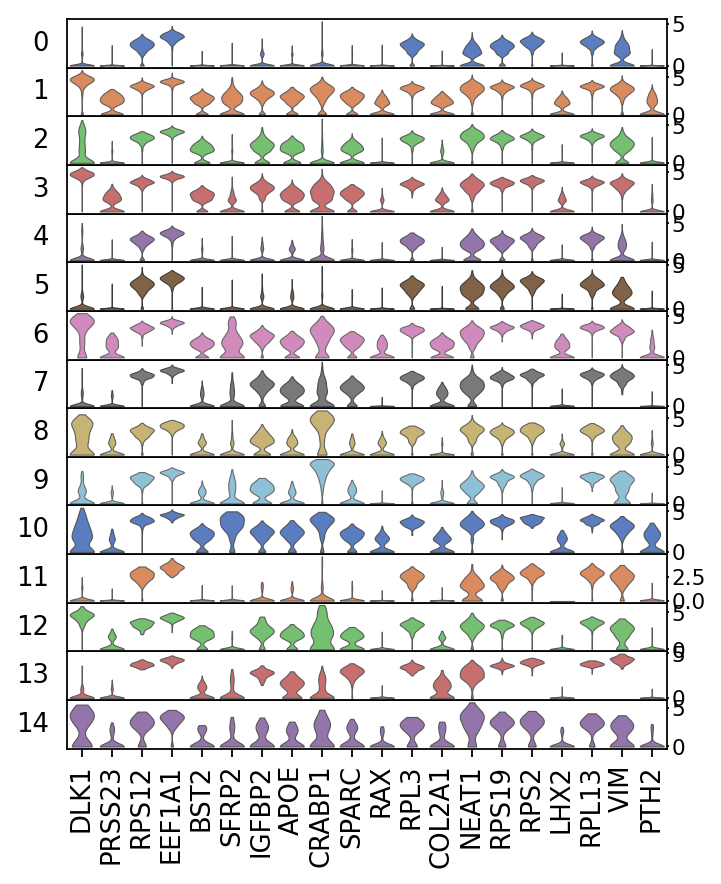

In [0]:
ax = sc.pl.stacked_violin(adata, marker_genes_cluster1, groupby='leiden', rotation=90)

# Save the work
option: export a set of csv using 
adata.write_csvs(results_file[:-5])

In [0]:
adata.write(results_file)

In [0]:
%ls

cellSNP/                                pool_iPSC_before_neighbors.h5ad
demultiplexing_pool_iPSC_21April.ipynb  scanpy_out/
figures/                                scanpy_pool_iPSC.ipynb
filtered_feature_bc_matrix/             vireo/
filtered_feature_bc_matrix.h5
